In [1]:
import torch
import torch.nn as nn
import torchvision
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from tqdm import tqdm

from vae import VAE

In [2]:
device = None

try:
    import torch_directml
    device = torch_directml.device()
except ModuleNotFoundError:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
device

device(type='privateuseone', index=0)

In [3]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

dataset = torchvision.datasets.MNIST(root='../data', train=True, transform=transform, download=True)
dataloader = DataLoader(dataset=dataset, batch_size=32, shuffle=True, num_workers=10)
gen_dataloader = DataLoader(dataset=dataset, batch_size=1, shuffle=True, num_workers=10)

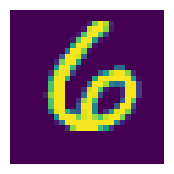

In [8]:
sample = next(iter(dataloader))

plt.figure(figsize=(2, 2))
plt.imshow(sample[0][0].permute(1, 2, 0))
plt.axis('off')
plt.show()

In [9]:
model = VAE(28 * 28).to(device)
model.load_state_dict(torch.load('vae.pth'))

optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
criterion = nn.BCEWithLogitsLoss(reduction='sum')

In [10]:
recon_losses = []
kl_losses = []

In [7]:
num_epochs = 10

model.train()
with torch.inference_mode(False):

    for epoch in range(num_epochs):

        loop = tqdm(enumerate(dataloader), total=len(dataloader))

        for step, (x, _) in loop:

            # forward
            x = x.to(device)
            x = x.view(-1, 28 * 28)
            out, mu, logvar = model(x)

            # loss
            recon_loss = criterion(out, x)
            kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
            loss = recon_loss + kl_loss

            recon_losses.append(recon_loss.item())
            kl_losses.append(kl_loss.item())
            
            loop.set_postfix(loss=loss.item())

            # backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

  0%|          | 0/1875 [00:00<?, ?it/s]/home/chickencurry/miniconda3/envs/directml/lib/python3.11/site-packages/torch/nn/functional.py:3226: UserWarning: The operator 'aten::log_sigmoid_forward' is not currently supported on the DML backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /__w/1/s/pytorch-directml-plugin/torch_directml/csrc/dml/dml_cpu_fallback.cpp:15.)
  return torch.binary_cross_entropy_with_logits(input, target, weight, pos_weight, reduction_enum)
100%|██████████| 1875/1875 [01:23<00:00, 22.34it/s, loss=3.52e+3]


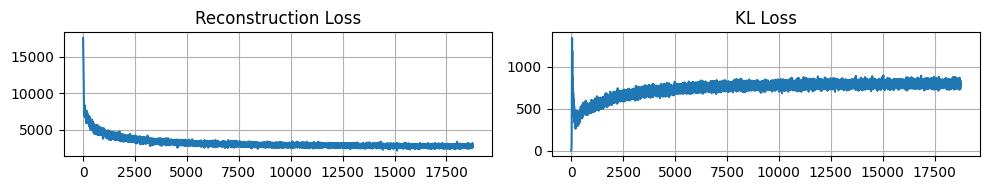

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(10, 2))

ax[0].plot(recon_losses)
ax[0].set_title('Reconstruction Loss')
ax[0].grid()

ax[1].plot(kl_losses)
ax[1].set_title('KL Loss')
ax[1].grid()

plt.tight_layout()
plt.show()

In [79]:
mus = []
labels = []

num_samples = 10000

for i, (x, y) in tqdm(enumerate(gen_dataloader), total=num_samples):
    mu, _ = model.encode(x.view(x.shape[0], 28 * 28).to(device))
    mus.append(mu.cpu().detach().numpy())
    labels.append(y.cpu().detach().numpy())

    if i + 1 == num_samples:
        break

100%|█████████▉| 9999/10000 [00:17<00:00, 579.83it/s]


In [80]:
import numpy as np
from sklearn.manifold import TSNE

X = np.array([m[0] for m in mus])
X_embedded = TSNE(n_components=2).fit_transform(X)

(1, 20)


(10000, 2)


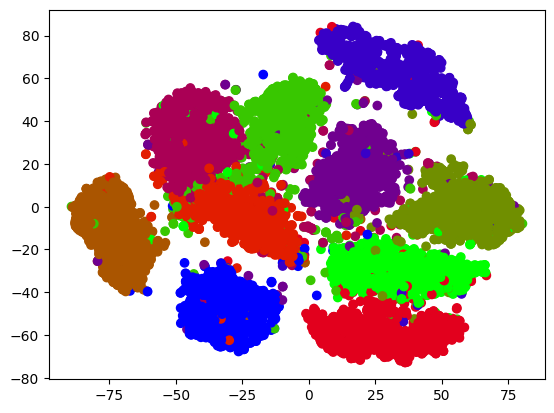

In [84]:
print(X_embedded.shape)

plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=labels, cmap='brg')

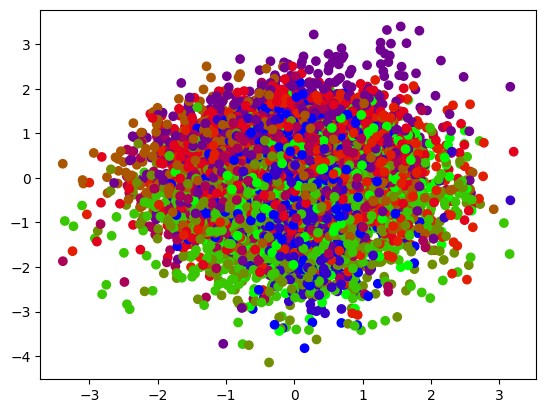

In [90]:
plt.scatter([m[0][0] for m in mus], [m[0][5] for m in mus], c=labels, cmap='brg')
plt.show()

In [25]:
torch.save(model.state_dict(), 'vae.pth')

In [13]:
def get_mu_and_logvar(model, device, digit, dataloader):

    model = model.to(device)
    model.eval()

    with torch.inference_mode():
        for x, y in dataloader:
            if y[0] == digit:
                x = x.to(device)
                x = x.view(x.shape[0], 28 * 28)
                mu, logvar = model.encode(x)
                return mu[0], logvar[0]

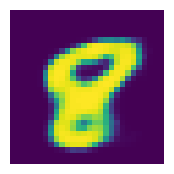

In [73]:
mu, logvar = get_mu_and_logvar(model, "cpu", 8, gen_dataloader)
sample = model.sample(mu, logvar, num_samples=1).view(28, 28).cpu().detach().numpy()

plt.figure(figsize=(2, 2))
plt.imshow(sample)
plt.axis('off')
plt.show()

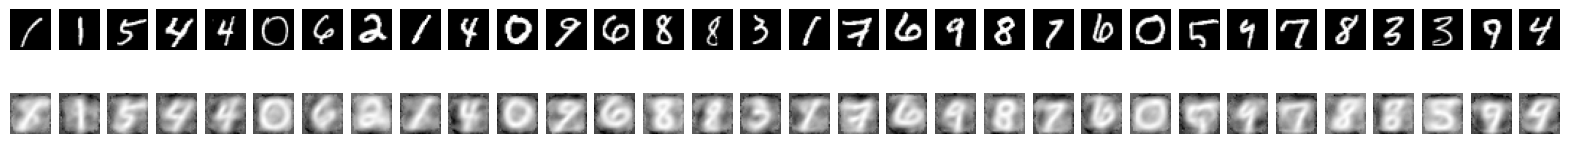

In [64]:
model = model.to(device)

input = next(iter(dataloader))[0].to(device)
recon, _, _ = model(input.view(-1, 28 * 28))

fig, ax = plt.subplots(2, input.shape[0], figsize=(20, 2))

for i in range(input.shape[0]):
    ax[0, i].imshow(input[i].view(-1, 28, 28)[0].cpu().detach().numpy(), cmap='gray')
    ax[0, i].axis('off')
    ax[1, i].imshow(recon[i].view(-1, 28, 28)[0].cpu().detach().numpy(), cmap='gray')
    ax[1, i].axis('off')

plt.show()